### Connecting to the postgis using sqlalchemy and manipulating the tables as geodataframes

In [3]:
import os
import sqlalchemy as db
import pandas as pd
import geopandas as gpd
from dotenv import load_dotenv

# Load the environment variables from the .env file
load_dotenv()


# Connect to the PostgreSQL database using SQLAlchemy
engine = db.create_engine('postgresql://{user}:{pw}@{host}/{db}'
                           .format(user=os.environ.get("POSTGIS_USER"),
                                   pw=os.environ.get("POSTGIS_PASSWORD"),
                                   host=os.environ.get('POSTGIS_HOST'),
                                   db=os.environ.get("POSTGIS_DATABASE"),
                                   port='5432'))
connection = engine.connect()

# Define SQL query to retrieve list of tables
#sql_query = "SELECT table_name FROM information_schema.tables WHERE table_schema = 'public'"

query = "SELECT * FROM nodes LIMIT 500"

# Use pandas to read the SQL query into a dataframe
#table_list_df = pd.read_sql(sql_query, engine)

# Use geopandas to read the SQL query into a dataframe from postgis
table_list_gdf = gpd.read_postgis(query, engine)

# read timestamp type data as string
table_list_gdf['tstamp']=table_list_gdf['tstamp'].dt.strftime('%Y-%m-%d %H:%M:%S')

table_list_gdf.head()

,id,version,user_id,tstamp,changeset_id,tags,geom
0,106904,5,4948143,2020-06-15 21:23:35,86684855,"{'waterway': 'lock_gate', 'seamark:type': 'gate'}",POINT (-0.03623 51.51956)
1,108735,6,4948143,2020-06-15 21:23:35,86684855,"{'waterway': 'lock_gate', 'seamark:type': 'gate'}",POINT (-0.03489 51.51475)
2,110210,7,4948143,2020-06-15 21:23:35,86684855,"{'waterway': 'lock_gate', 'seamark:type': 'gate'}",POINT (-0.03777 51.52499)
3,142325,5,53773,2017-04-26 16:43:20,48165623,{},POINT (6.16037 49.11819)
4,148969,14,420980,2018-10-23 13:53:56,63792931,{},POINT (11.23781 60.42730)


#### Visualize geodataframe using the explore method in geopandas

In [4]:
table_list_gdf.explore()

#### Creating a function for formatting the tags column

In [5]:
# Define a function to format the lengthy dict column
def format_dict(d):
    # Split the dict into several lines
    lines = [f"{k}: {v}" for k, v in d.items()]
    return "<br>".join(lines)

In [6]:
# Apply the formatting function to the dict column
table_list_gdf['tags'] = table_list_gdf['tags'].apply(format_dict)
table_list_gdf

,id,version,user_id,tstamp,changeset_id,tags,geom
0,106904,5,4948143,2020-06-15 21:23:35,86684855,waterway: lock_gate<br>seamark:type: gate,POINT (-0.03623 51.51956)
1,108735,6,4948143,2020-06-15 21:23:35,86684855,waterway: lock_gate<br>seamark:type: gate,POINT (-0.03489 51.51475)
2,110210,7,4948143,2020-06-15 21:23:35,86684855,waterway: lock_gate<br>seamark:type: gate,POINT (-0.03777 51.52499)
3,142325,5,53773,2017-04-26 16:43:20,48165623,,POINT (6.16037 49.11819)
4,148969,14,420980,2018-10-23 13:53:56,63792931,,POINT (11.23781 60.42730)
...,...,...,...,...,...,...,...
495,13874211,6,1196017,2018-07-20 06:20:55,60888892,,POINT (12.54601 55.63929)
496,13874225,6,1196017,2018-07-20 06:20:55,60888892,,POINT (12.54431 55.63840)
497,13874227,8,1196017,2018-07-20 06:20:55,60888892,,POINT (12.54337 55.63794)
498,13874232,18,1196017,2018-07-20 06:20:55,60888892,,POINT (12.54074 55.63652)


#### Creating openseamap with geodataframe overlay

In [7]:
import folium

# Create a map centered on Germany with a zoom level of 6
map = folium.Map(location=[51.1657, 10.4515], zoom_start=6)

# Add OpenSeaMap tiles as a base layer
folium.TileLayer('http://tiles.openseamap.org/seamark/{z}/{x}/{y}.png',
                 name='OpenSeaMap',
                 attr='Map data © OpenSeaMap contributors').add_to(map)


#Add geodataframe to the map 
folium.GeoJson(table_list_gdf[:100],popup=folium.GeoJsonPopup(fields=list(table_list_gdf.columns[:-1]))).add_to(map)

               
# Display the map
map

#### Download urls of seamarks, coastline,water polygons and land polygons

* Pre-extracted seamarks: 
http://tiles.openseamap.org/seamark/world.osm

* coastlines:
https://osmdata.openstreetmap.de/data/coastlines.html

* water polygons:
https://osmdata.openstreetmap.de/data/water-polygons.html

* land polygons:
https://osmdata.openstreetmap.de/data/land-polygons.html



#### Using bounding box with shapefile

In [8]:
import geopandas as gpd
from shapely.geometry import box

# define the bounding box coordinates
minx, miny, maxx, maxy = 9.5, 53, 30, 66

# create a shapely geometry object from the bounding box coordinates
bbox = box(minx, miny, maxx, maxy)
epsg_code = '4326'


# read the shapefile and subset it to the bounding box
gdf_land = gpd.read_file('C:/Users/Surendra/Downloads/coastlines-split/lines.shp', bbox=bbox)
gdf_land.head()

,FID,geometry
0,11,"LINESTRING (12.93414 55.46239, 12.93354 55.462..."
1,12,"LINESTRING (12.94159 55.46074, 12.94109 55.460..."
2,13,"LINESTRING (12.93662 55.45915, 12.93671 55.459..."
3,14,"LINESTRING (12.50693 55.63490, 12.50706 55.634..."
4,135,"LINESTRING (17.67078 59.15960, 17.67018 59.159..."


In [ ]:
#Visualize coastlines using explore method of geopandas
gdf_land.explore()

#### Overlay coastline data to the existing openseamap

In [9]:
#add coastline data to the map
folium.GeoJson(gdf_land[:100]).add_to(map)
#folium.GeoJson(gdf_land[:100],popup=folium.GeoJsonPopup(fields=('FID',))).add_to(map)
map

#### Using bounding box while querying from the postgis

In [44]:
#importing shapely to create bounding box geometry
from shapely.geometry import box

min_lon, min_lat, max_lon, max_lat = 9.5, 53, 30, 66
bbox = box(min_lon, min_lat, max_lon, max_lat)

# convert the bounding box geometry to a WKT string
bbox_wkt = bbox.wkt

# create a SQL query that selects the features within the bounding box
query = "SELECT * FROM nodes WHERE ST_Intersects(geom, ST_GeomFromText('{}', 4326))".format(bbox_wkt)

# read the features within the bounding box from the PostGIS database
df = gpd.read_postgis(query, con=connection, geom_col='geom')
df['tags'][400:500]

400                                                   {}
401                                    {'source': 'PGS'}
402    {'name': 'Rerik', 'ferry': 'yes', 'amenity': '...
403                                                   {}
404                                                   {}
                             ...                        
495                                                   {}
496                                                   {}
497                                                   {}
498                                                   {}
499                                                   {}
Name: tags, Length: 100, dtype: object

In [43]:
#converting the timestamp datatype to string
df['tstamp']=df['tstamp'].dt.strftime('%Y-%m-%d %H:%M:%S')
df[:100].explore()

In [60]:
#checking the seamark tags for 1000 elements
for k, v in df['tags'][:1000].items():
    if v == {}:  #checks and  displays non empty dictionaries
        continue
    print(v)

{'amenity': 'ferry_terminal'}
{'bus': 'yes', 'name': 'Helsingborg', 'cargo': 'passengers;vehicle', 'ferry': 'yes', 'amenity': 'ferry_terminal', 'public_transport': 'stop_position'}
{'source': 'PGS', 'created_by': 'almien_coastlines'}
{'source': 'PGS'}
{'source': 'PGS'}
{'source': 'PGS', 'created_by': 'almien_coastlines'}
{'source': 'PGS', 'created_by': 'almien_coastlines'}
{'source': 'PGS', 'created_by': 'almien_coastlines'}
{'source': 'PGS'}
{'source': 'PGS'}
{'source': 'PGS'}
{'source': 'PGS'}
{'source': 'PGS'}
{'source': 'PGS'}
{'source': 'PGS'}
{'source': 'PGS'}
{'source': 'PGS'}
{'source': 'PGS'}
{'source': 'PGS'}
{'source': 'PGS'}
{'name': 'Rerik', 'ferry': 'yes', 'amenity': 'ferry_terminal', 'wheelchair': 'limited', 'public_transport': 'station'}
{'created_by': 'JOSM'}
{'created_by': 'JOSM'}
{'leisure': 'slipway', 'seamark:type': 'small_craft_facility', 'seamark:small_craft_facility:category': 'slipway'}
{'source': 'PGS'}
{'source': 'PGS'}
{'source': 'Hansestadt Lübeck, Bereich 

In [13]:
# query for water polygon table from postgis

query = "SELECT * FROM water_polygons "

# Use pandas to read the SQL query into a dataframe
#table_list_df = pd.read_sql(sql_query, engine)

# Use geopandas to read the SQL query into a dataframe from postgis
water_gdf = gpd.read_postgis(query, engine,geom_col='the_geom')

# read timestamp type data as string
#water_gdf['tstamp']=table_list_gdf['tstamp'].dt.strftime('%Y-%m-%d %H:%M:%S')

water_gdf.head()

,fid,the_geom,x,y
0,1,"MULTIPOLYGON (((-11.00158 -71.04059, -10.99839...",-11,-72
1,2,"MULTIPOLYGON (((-10.73509 -71.00256, -10.71424...",-11,-72
2,3,"MULTIPOLYGON (((149.00051 -11.00050, 147.99949...",148,-11
3,4,"MULTIPOLYGON (((-25.99907 -56.99950, -25.99907...",-27,-58
4,5,"MULTIPOLYGON (((116.00050 7.00050, 116.00050 5...",115,6


<AxesSubplot:>

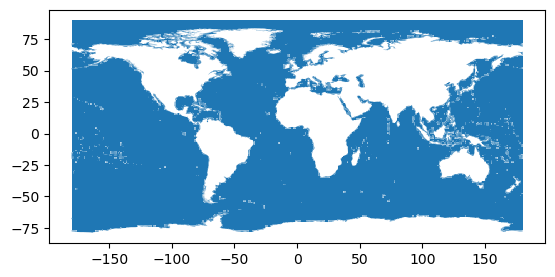

In [18]:
water_gdf.plot()

In [15]:
bbox=(5.221750,53.250549,6.787199,53.681208)

<AxesSubplot:>

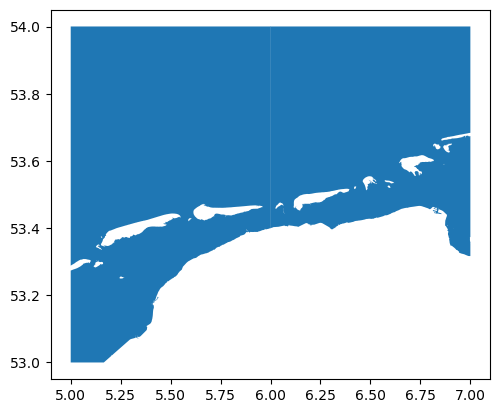

In [17]:
# Filter the GeoDataFrame to only include features within the bounding box
water_bbox = water_gdf.cx[bbox[0]:bbox[2], bbox[1]:bbox[3]]

# Visualize the filtered GeoDataFrame
water_bbox.plot()

#water_gdf.explore()

In [19]:
#sql_query = "SELECT table_name FROM information_schema.tables WHERE table_schema = 'public'"

query = "SELECT * FROM lines "

# Use pandas to read the SQL query into a dataframe
#table_list_df = pd.read_sql(sql_query, engine)

# Use geopandas to read the SQL query into a dataframe from postgis
lines_gdf = gpd.read_postgis(query, engine,geom_col='the_geom')

lines_gdf.head()

,fid_1,the_geom,FID
0,1,"MULTILINESTRING ((-4.94237 55.72545, -4.94192 ...",0
1,2,"MULTILINESTRING ((-4.94051 55.72458, -4.94049 ...",1
2,3,"MULTILINESTRING ((-4.73290 55.52496, -4.73380 ...",2
3,4,"MULTILINESTRING ((-4.95385 55.16290, -4.95388 ...",3
4,5,"MULTILINESTRING ((-1.75372 50.72274, -1.75350 ...",4


<AxesSubplot:>

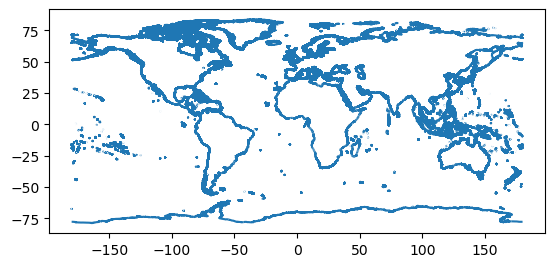

In [21]:
lines_gdf.plot()